 # FashionMNIST

 ## Задание 7.2

<img src="https://emiliendupont.github.io/imgs/mnist-chicken/mnist-and-fashion-examples.png">

На практике построим нейронную сеть для классификации картиной. В качестве входных данных используются картинки одежды (в градациях серого, то есть цветовых каналов не 3, а 1). По входной картинке нужно предсказать тип одежды.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
from torchvision import transforms
from torchsummary import summary

import torch.nn as nn
import torch.nn.functional as F

import pandas as pd
from tqdm import notebook

Скачаем обучающую и контрольную выборки.

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor()])

trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = {0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat', 5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'}

Каждая картинка имеет класс от 0 до 9, расшифровка меток класса:  

|class_id|class_name|
|----|----|
|0| T-shirt/top|
|1| Trouser|
|2| Pullover|
|3| Dress|
|4| Coat|
|5| Sandal|
|6| Shirt|
|7| Sneaker|
|8| Bag|
|9| Ankle boot| 

## Задание

Посмотрите на датасет.
* Сколько картинок в train? В test?
* Равномерно ли распределено количество объектов разных классов в train датасете (это можно понять, поработав с полем `train_data` у переменной `trainset`)? в test?
* Выведите несколько картинок с помощью `pyplot`

Используя материалы семинаров по многослойным  и свёрточным сетям, напишите:
1.  Многослойную нейронную сеть MLP (Multi-Layer Perceptron) классифицирующую этот датасет
2. Свёрточную сеть, классифицирующую этот датасет
3. Сравните их качество (по графикам лосса и по Accuracy Score)

Если качество, которое получается у  нейросети, выше 95%, то Вы решили задачу с точностью, которую можно использовать в жизни.

### Размер выборок

In [ ]:
trainset.data.shape

torch.Size([60000, 28, 28])

In [ ]:
testset.data.shape

torch.Size([10000, 28, 28])

### Распределение объектов по классам

In [ ]:
pd_trainset = pd.DataFrame(trainset.targets.numpy())

for i in range(10):
  print('Class ', i, ': ', (pd_trainset == i).sum())

Class  0 :  0    6000
dtype: int64
Class  1 :  0    6000
dtype: int64
Class  2 :  0    6000
dtype: int64
Class  3 :  0    6000
dtype: int64
Class  4 :  0    6000
dtype: int64
Class  5 :  0    6000
dtype: int64
Class  6 :  0    6000
dtype: int64
Class  7 :  0    6000
dtype: int64
Class  8 :  0    6000
dtype: int64
Class  9 :  0    6000
dtype: int64


In [ ]:
pd_testset = pd.DataFrame(testset.targets.numpy())
for i in range(10):
  print('Class ', i, ': ', (pd_testset == i).sum())

Class  0 :  0    1000
dtype: int64
Class  1 :  0    1000
dtype: int64
Class  2 :  0    1000
dtype: int64
Class  3 :  0    1000
dtype: int64
Class  4 :  0    1000
dtype: int64
Class  5 :  0    1000
dtype: int64
Class  6 :  0    1000
dtype: int64
Class  7 :  0    1000
dtype: int64
Class  8 :  0    1000
dtype: int64
Class  9 :  0    1000
dtype: int64


### Вывод картинок

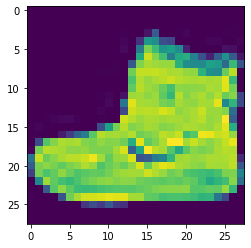

In [ ]:
plt.imshow(trainset.data[0])

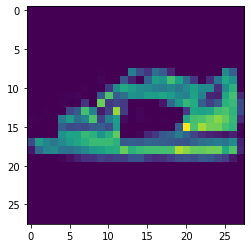

In [ ]:
plt.imshow(trainset.data[13])

### Многослойная нейронная сеть MLP

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
MLP_net = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(784, 256),
    torch.nn.ReLU(),  
    torch.nn.Dropout(0.2),
    torch.nn.Linear(256, 256),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.5),
    torch.nn.Linear(256, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 10)
)

loss_fn = torch.nn.CrossEntropyLoss(size_average=False)

learning_rate = 1e-3
optimizer = torch.optim.SGD(MLP_net.parameters(), lr=learning_rate)

In [ ]:
MLP_net.to(device)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.2, inplace=False)
  (4): Linear(in_features=256, out_features=256, bias=True)
  (5): ReLU()
  (6): Dropout(p=0.5, inplace=False)
  (7): Linear(in_features=256, out_features=128, bias=True)
  (8): ReLU()
  (9): Linear(in_features=128, out_features=64, bias=True)
  (10): ReLU()
  (11): Linear(in_features=64, out_features=10, bias=True)
)

In [ ]:
loss_history = []

for epoch in notebook.tqdm(range(10)):

    running_loss = 0.0
    for i, batch in enumerate(notebook.tqdm(trainloader)):
        # получение текущего батча
        X_batch, y_batch = batch
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        # обнуление весов
        optimizer.zero_grad()

        # forward + backward + optimize
        y_pred = MLP_net(X_batch)
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        # вывод текущего loss
        running_loss += loss.item()
        

        # вывод качества каждые 2000 батчей
        if i % 2000 == 1999:
            loss_history.append(running_loss / 2000)

            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('END')

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

[1,  2000] loss: 9.183
[1,  4000] loss: 7.840
[1,  6000] loss: 4.843
[1,  8000] loss: 3.796
[1, 10000] loss: 3.452
[1, 12000] loss: 3.152
[1, 14000] loss: 2.786


  0%|          | 0/15000 [00:00<?, ?it/s]

[2,  2000] loss: 2.497
[2,  4000] loss: 2.422
[2,  6000] loss: 2.289
[2,  8000] loss: 2.186
[2, 10000] loss: 2.149
[2, 12000] loss: 2.042
[2, 14000] loss: 2.048


  0%|          | 0/15000 [00:00<?, ?it/s]

[3,  2000] loss: 2.033
[3,  4000] loss: 1.890
[3,  6000] loss: 1.869
[3,  8000] loss: 1.798
[3, 10000] loss: 1.756
[3, 12000] loss: 1.881
[3, 14000] loss: 1.805


  0%|          | 0/15000 [00:00<?, ?it/s]

[4,  2000] loss: 1.777
[4,  4000] loss: 1.629
[4,  6000] loss: 1.758
[4,  8000] loss: 1.733
[4, 10000] loss: 1.729
[4, 12000] loss: 1.633
[4, 14000] loss: 1.643


  0%|          | 0/15000 [00:00<?, ?it/s]

[5,  2000] loss: 1.633
[5,  4000] loss: 1.612
[5,  6000] loss: 1.577
[5,  8000] loss: 1.590
[5, 10000] loss: 1.593
[5, 12000] loss: 1.563
[5, 14000] loss: 1.610


  0%|          | 0/15000 [00:00<?, ?it/s]

[6,  2000] loss: 1.511
[6,  4000] loss: 1.497
[6,  6000] loss: 1.532
[6,  8000] loss: 1.551
[6, 10000] loss: 1.513
[6, 12000] loss: 1.450
[6, 14000] loss: 1.480


  0%|          | 0/15000 [00:00<?, ?it/s]

[7,  2000] loss: 1.468
[7,  4000] loss: 1.484
[7,  6000] loss: 1.433
[7,  8000] loss: 1.435
[7, 10000] loss: 1.423
[7, 12000] loss: 1.445
[7, 14000] loss: 1.447


  0%|          | 0/15000 [00:00<?, ?it/s]

[8,  2000] loss: 1.414
[8,  4000] loss: 1.384
[8,  6000] loss: 1.415
[8,  8000] loss: 1.384
[8, 10000] loss: 1.442
[8, 12000] loss: 1.375
[8, 14000] loss: 1.397


  0%|          | 0/15000 [00:00<?, ?it/s]

[9,  2000] loss: 1.385
[9,  4000] loss: 1.384
[9,  6000] loss: 1.362
[9,  8000] loss: 1.335
[9, 10000] loss: 1.305
[9, 12000] loss: 1.367
[9, 14000] loss: 1.342


  0%|          | 0/15000 [00:00<?, ?it/s]

[10,  2000] loss: 1.340
[10,  4000] loss: 1.334
[10,  6000] loss: 1.373
[10,  8000] loss: 1.326
[10, 10000] loss: 1.323
[10, 12000] loss: 1.327
[10, 14000] loss: 1.185
END


In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)

        y_pred = MLP_net(images)
        _, predicted = torch.max(y_pred, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d%%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))
    
print('\nOverall cccuracy: ', (sum(class_correct) / sum(class_total)) * 100, '%')

Accuracy of T-shirt/top : 76%
Accuracy of Trouser : 95%
Accuracy of Pullover : 75%
Accuracy of Dress : 88%
Accuracy of  Coat : 70%
Accuracy of Sandal : 95%
Accuracy of Shirt : 70%
Accuracy of Sneaker : 88%
Accuracy of   Bag : 95%
Accuracy of Ankle boot : 97%

Overall cccuracy:  85.32 %


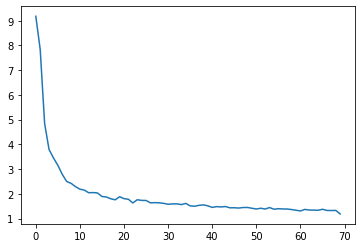

In [ ]:
plt.plot(loss_history, label='loss')

### Сверточная нейронная сеть

In [ ]:
class ConvNet(nn.Module):
    def __init__(self):
        # вызов конструктора класса nn.Module()
        super(ConvNet, self).__init__()
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5)
        
        self.fc1 = nn.Linear(2 * 2 * 32, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(self.conv3(F.relu(self.conv2(x))))
        x = x.view(-1, 2 * 2 * 32)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
# объявление сети
conv_net = ConvNet()
conv_net.to(device)

# выбор функции потерь
loss_fn = torch.nn.CrossEntropyLoss()

# выбор алгоритма оптимизации и learning_rate
learning_rate = 1e-4
optimizer = torch.optim.Adam(conv_net.parameters(), lr=learning_rate)

In [ ]:
summary(conv_net, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 24, 24]             156
         MaxPool2d-2            [-1, 6, 12, 12]               0
            Conv2d-3             [-1, 16, 8, 8]           2,416
            Conv2d-4             [-1, 32, 4, 4]          12,832
         MaxPool2d-5             [-1, 32, 2, 2]               0
            Linear-6                  [-1, 120]          15,480
            Linear-7                   [-1, 84]          10,164
            Linear-8                   [-1, 10]             850
Total params: 41,898
Trainable params: 41,898
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.05
Params size (MB): 0.16
Estimated Total Size (MB): 0.21
----------------------------------------------------------------


In [ ]:
# итерирование
cnn_loss_history = []

for epoch in notebook.tqdm(range(10)):

    running_loss = 0.0
    for i, batch in enumerate(notebook.tqdm(trainloader)):
        # получение текущего батча
        X_batch, y_batch = batch
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        # обнуление весов
        optimizer.zero_grad()

        # forward + backward + optimize
        y_pred = conv_net(X_batch)
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        # вывод текущего loss
        running_loss += loss.item()


        # вывод качества каждые 2000 батчей
        if i % 2000 == 1999:
            cnn_loss_history.append(running_loss / 2000)

            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('END')

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

[1,  2000] loss: 1.254
[1,  4000] loss: 0.854
[1,  6000] loss: 0.791
[1,  8000] loss: 0.711
[1, 10000] loss: 0.680
[1, 12000] loss: 0.671
[1, 14000] loss: 0.636


  0%|          | 0/15000 [00:00<?, ?it/s]

[2,  2000] loss: 0.596
[2,  4000] loss: 0.595
[2,  6000] loss: 0.551
[2,  8000] loss: 0.549
[2, 10000] loss: 0.538
[2, 12000] loss: 0.523
[2, 14000] loss: 0.533


  0%|          | 0/15000 [00:00<?, ?it/s]

[3,  2000] loss: 0.496
[3,  4000] loss: 0.490
[3,  6000] loss: 0.474
[3,  8000] loss: 0.458
[3, 10000] loss: 0.452
[3, 12000] loss: 0.453
[3, 14000] loss: 0.451


  0%|          | 0/15000 [00:00<?, ?it/s]

[4,  2000] loss: 0.433
[4,  4000] loss: 0.426
[4,  6000] loss: 0.426
[4,  8000] loss: 0.416
[4, 10000] loss: 0.411
[4, 12000] loss: 0.419
[4, 14000] loss: 0.396


  0%|          | 0/15000 [00:00<?, ?it/s]

[5,  2000] loss: 0.392
[5,  4000] loss: 0.385
[5,  6000] loss: 0.395
[5,  8000] loss: 0.393
[5, 10000] loss: 0.377
[5, 12000] loss: 0.374
[5, 14000] loss: 0.366


  0%|          | 0/15000 [00:00<?, ?it/s]

[6,  2000] loss: 0.363
[6,  4000] loss: 0.355
[6,  6000] loss: 0.356
[6,  8000] loss: 0.366
[6, 10000] loss: 0.359
[6, 12000] loss: 0.350
[6, 14000] loss: 0.360


  0%|          | 0/15000 [00:00<?, ?it/s]

[7,  2000] loss: 0.337
[7,  4000] loss: 0.351
[7,  6000] loss: 0.326
[7,  8000] loss: 0.353
[7, 10000] loss: 0.335
[7, 12000] loss: 0.344
[7, 14000] loss: 0.332


  0%|          | 0/15000 [00:00<?, ?it/s]

[8,  2000] loss: 0.314
[8,  4000] loss: 0.331
[8,  6000] loss: 0.337
[8,  8000] loss: 0.322
[8, 10000] loss: 0.327
[8, 12000] loss: 0.331
[8, 14000] loss: 0.314


  0%|          | 0/15000 [00:00<?, ?it/s]

[9,  2000] loss: 0.308
[9,  4000] loss: 0.305
[9,  6000] loss: 0.302
[9,  8000] loss: 0.315
[9, 10000] loss: 0.324
[9, 12000] loss: 0.326
[9, 14000] loss: 0.299


  0%|          | 0/15000 [00:00<?, ?it/s]

[10,  2000] loss: 0.288
[10,  4000] loss: 0.284
[10,  6000] loss: 0.311
[10,  8000] loss: 0.303
[10, 10000] loss: 0.294
[10, 12000] loss: 0.301
[10, 14000] loss: 0.318
END


In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)

        y_pred = conv_net(images)
        _, predicted = torch.max(y_pred, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d%%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))
    
print('\nOverall cccuracy: ', (sum(class_correct) / sum(class_total)) * 100, '%')

Accuracy of T-shirt/top : 78 %
Accuracy of Trouser : 95 %
Accuracy of Pullover : 73 %
Accuracy of Dress : 92 %
Accuracy of  Coat : 77 %
Accuracy of Sandal : 96 %
Accuracy of Shirt : 73 %
Accuracy of Sneaker : 91 %
Accuracy of   Bag : 97 %
Accuracy of Ankle boot : 95 %

Overall cccuracy:  87.15 %


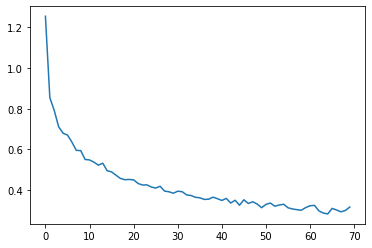

In [ ]:
plt.plot(cnn_loss_history, label='loss')

### Вывод
Сверточная нейронная сеть требует больше времени на обучение, однако показывает более хорошие результаты относительно MLP